In [1]:
import wntr
import matplotlib
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
from scipy.stats import expon

In [2]:
np.random.seed(12345)

In [3]:
cmap=matplotlib.colormaps['viridis']

In [4]:
inp_file='/home/wahab901278/Downloads/Net3.inp'

In [5]:
wn=wntr.network.WaterNetworkModel(inp_file)

In [6]:
wn=wntr.morph.scale_node_coordinates(wn,1000)

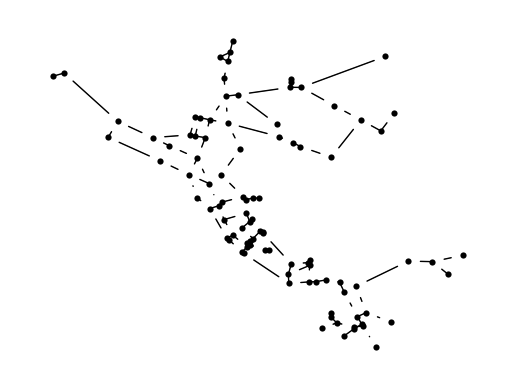

<Axes: >

In [7]:
wntr.graphics.plot_network(wn)

In [8]:
epicenter=(32000,15000)
magnitude=6.5
depth=10000

In [9]:
total_duration=24*3600
minimum_pressure=3.52
required_pressure=14.06

leak_start_time=5*3600
leak_repair_time=15*3600

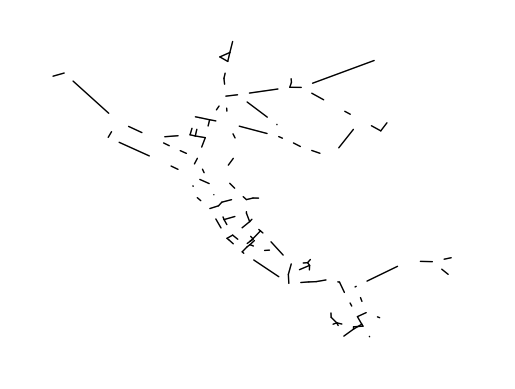

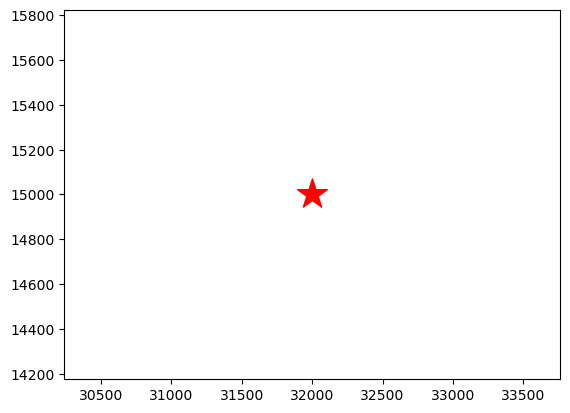

In [10]:
wntr.graphics.plot_network(wn,node_size=0)
plt.scatter(epicenter[0],epicenter[1],s=500,c='r',marker='*',zorder=2)

In [11]:
earthquake=wntr.scenario.Earthquake(epicenter,magnitude,depth)

In [12]:

R=earthquake.distance_to_epicenter(wn,element_type=wntr.network.Pipe)

In [13]:
pga=earthquake.pga_attenuation_model(R)
pgv=earthquake.pgv_attenuation_model(R)
RR=earthquake.repair_rate_model(pgv)

In [14]:
L=wn.query_link_attribute('length',link_type=wntr.network.Pipe)

In [15]:
pipe_FC=wntr.scenario.FragilityCurve()
pipe_FC.add_state('Minor Leak',1,{'Default':expon(scale=0.2)})
pipe_FC.add_state('Major Leak',2,{'Default':expon()})

<Figure size 640x480 with 0 Axes>

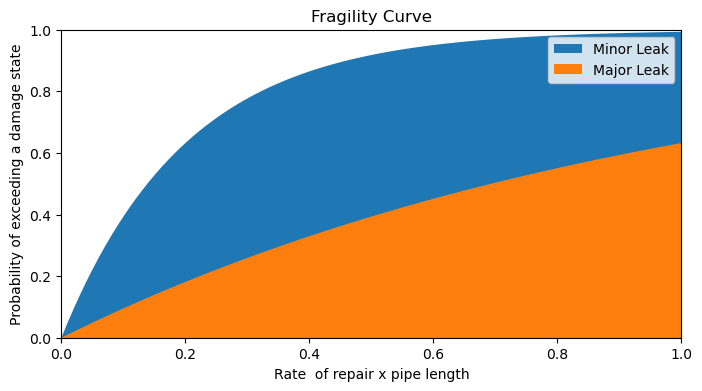

<Axes: title={'center': 'Fragility Curve'}, xlabel='Rate  of repair x pipe length', ylabel='Probability of exceeding a damage state'>

In [16]:
plt.figure()
wntr.graphics.plot_fragility_curve(pipe_FC,title="Fragility Curve",xlabel='Rate  of repair x pipe length')

In [17]:
pipe_Pr=pipe_FC.cdf_probability(RR*L)

In [18]:
pipe_damage_state=pipe_FC.sample_damage_state(pipe_Pr)

In [19]:
print('Min,Max, Average PGA:'+str(np.round(pga.min(),2))+","+str(np.round(pga.max(),2))+","+str(np.round(pga.mean(),2)))
print('Min,Max, Average PGV:'+str(np.round(pgv.min(),2))+","+str(np.round(pgv.max(),2))+","+str(np.round(pgv.mean(),2)))
print('Min,Max, Average RR:'+str(np.round(RR.min(),2))+","+str(np.round(RR.max(),2))+","+str(np.round(RR.mean(),2)))


Min,Max, Average PGA:0.14,0.27,0.22
Min,Max, Average PGV:0.21,0.63,0.43
Min,Max, Average RR:0.0,0.0,0.0


AttributeError: 'list' object has no attribute 'get_array'

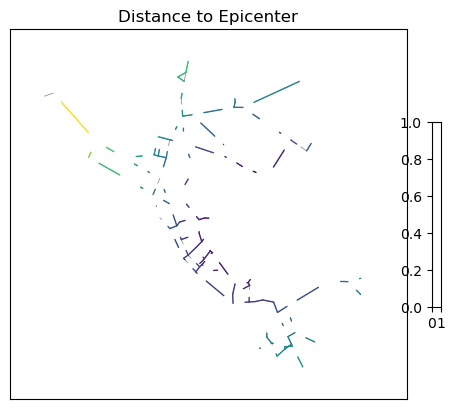

In [20]:

wntr.graphics.plot_network(wn,link_attribute=R,node_size=0,link_cmap=cmap,title='Distance to Epicenter')

AttributeError: 'list' object has no attribute 'get_array'

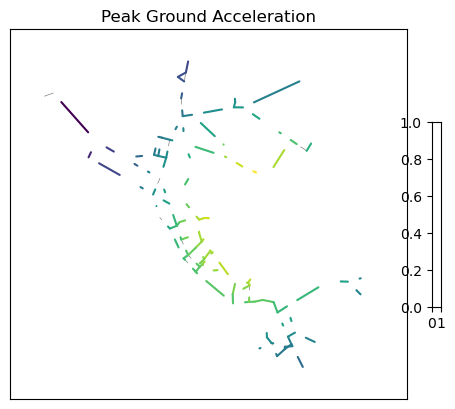

In [21]:
wntr.graphics.plot_network(wn,link_attribute=pga,node_size=0,link_cmap=cmap,link_width=1.5,title="Peak Ground Acceleration")

In [ ]:
wntr.graphics.plot_network(wn,link_attribute=pgv,node_size=0,link_cmap=cmap,link_width=1.5,title="Peak Ground Velocity")

AttributeError: 'list' object has no attribute 'get_array'

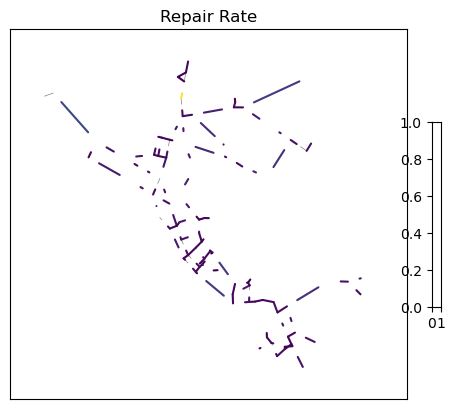

In [22]:
wntr.graphics.plot_network(wn,link_attribute=RR*L,node_size=0,link_cmap=cmap,link_width=1.5,title="Repair Rate")

AttributeError: 'list' object has no attribute 'get_array'

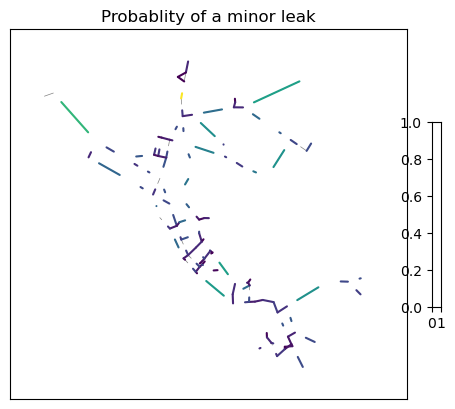

In [23]:
wntr.graphics.plot_network(wn,link_attribute=pipe_Pr['Minor Leak'],node_size=0,link_cmap=cmap,link_range=[0,1],link_width=1.5,title='Probablity of a minor leak')

AttributeError: 'list' object has no attribute 'get_array'

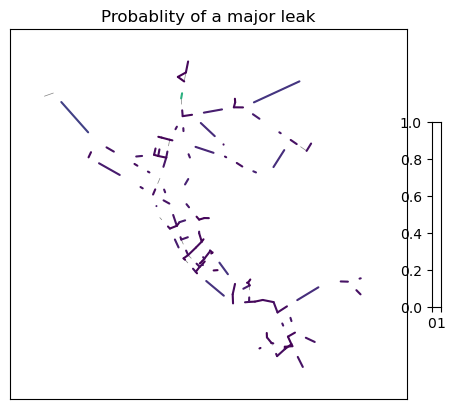

In [24]:
wntr.graphics.plot_network(wn,link_attribute=pipe_Pr['Major Leak'],node_size=0,link_cmap=cmap,link_range=[0,1],link_width=1.5,title='Probablity of a major leak')

In [20]:
wn.options.hydraulic.demand_model='PDD'
wn.options.time.duration=total_duration
wn.options.hydraulic.minimum_pressure=minimum_pressure
wn.options.hydraulic.required_pressure=required_pressure

In [22]:
for pipe_name,damage_state in pipe_damage_state.items():
    pipe_diameter=wn.get_link(pipe_name).diameter
    if damage_state is not None:
        if damage_state=='Major Leak':
            leak_diameter=0.25*pipe_diameter
            leak_area=np.pi/4*(leak_diameter)**2
        elif damage_state=='Minor Leak':
            leak_diameter=0.1 * pipe_diameter
            leak_area=np.pi/4*(leak_diameter)**2
        else:
            leak_area=0
        wn=wntr.morph.split_pipe(wn,pipe_name,new_pipe_name=pipe_name+'A',new_junction_name='Leak'+pipe_name)
        leak_node=wn.get_node('Leak'+pipe_name)
        leak_node.add_leak(wn,area=leak_area,start_time=leak_start_time)
sim=wntr.sim.WNTRSimulator(wn)
results=sim.run_sim()

In [28]:
leaked_demand=results.node['leak_demand']
leaked_sum=leaked_demand.sum()
leaked_sum.sort_values(ascending=False,inplace=True)

In [29]:
leaked_sum

Leak329    11.914779
Leak171     1.376890
Leak159     1.177374
Leak131     0.873048
Leak114     0.675844
             ...    
157         0.000000
153         0.000000
151         0.000000
149         0.000000
Lake        0.000000
Length: 113, dtype: float64

Text(0, 0.5, 'Leak Demand(m$3$/s)')

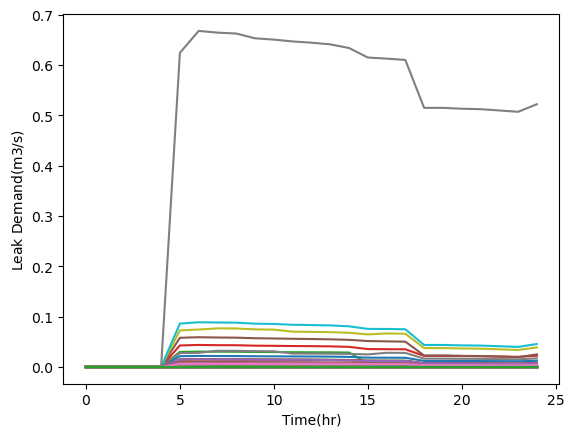

In [30]:
leaked_demand.index=leaked_demand.index/3600
ax=leaked_demand.plot(legend=False)
ax.set_xlabel('Time(hr)')
ax.set_ylabel('Leak Demand(m$3$/s)')

In [31]:
no_of_pipes_to_fix=5
pipes_to_fix=leaked_sum[0:no_of_pipes_to_fix]
print(pipes_to_fix)

Leak329    11.914779
Leak171     1.376890
Leak159     1.177374
Leak131     0.873048
Leak114     0.675844
dtype: float64


In [32]:
wn.reset_initial_values()

In [33]:
leaked_demand=results.node['leak_demand']
leaked_sum=leaked_demand.sum()
leaked_sum.sort_values(ascending=False,inplace=True)

In [34]:
for leak_name in pipes_to_fix.index:
    node=wn.get_node(leak_name)
    leak_area=node.leak_area
    node.remove_leak(wn)
    node.add_leak(wn,area=leak_area,start_time=leak_start_time,end_time=leak_repair_time)

In [35]:
results_wrepair=sim.run_sim()

In [36]:
pressure=results.node['pressure']
pressure_wrepair=results_wrepair.node['pressure']




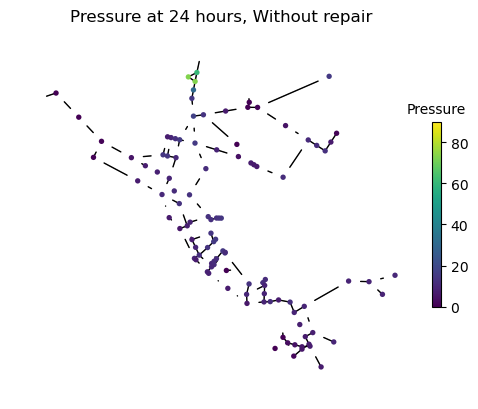

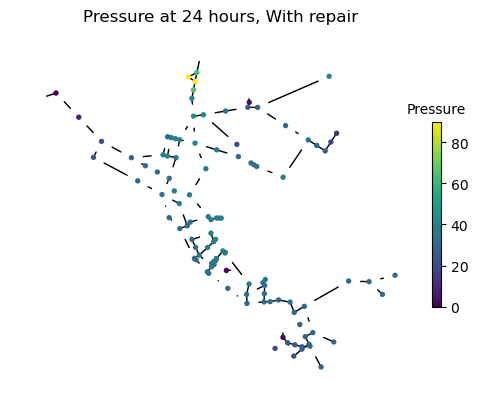

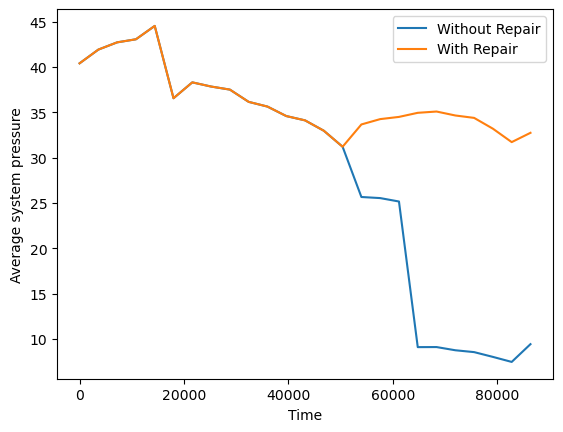

In [38]:
pressure_at_24hr=pressure.loc[86400,wn.junction_name_list]
wntr.graphics.plot_network(wn,node_attribute=pressure_at_24hr,node_size=15,node_range=[0,90],node_cmap=cmap,node_colorbar_label='Pressure',title='Pressure at 24 hours, Without repair')
pressure_at_24hr=pressure_wrepair.loc[86400,wn.junction_name_list]
wntr.graphics.plot_network(wn,node_attribute=pressure_at_24hr,node_size=15,node_range=[0,90],node_cmap=cmap,node_colorbar_label='Pressure',title='Pressure at 24 hours, With repair')

plt.figure()
ax=plt.gca()
pressure.loc[:,wn.junction_name_list].mean(axis=1).plot(label="Without Repair",ax=ax)
pressure_wrepair.loc[:,wn.junction_name_list].mean(axis=1).plot(label="With Repair",ax=ax)

ax.set_xlabel('Time')
ax.set_ylabel('Average system pressure')
ax.legend()

In [40]:
expected_demand=wntr.metrics.expected_demand(wn)
demand=results.node['demand'].loc[:,wn.junction_name_list]
demand_wrepair=results_wrepair.node['demand'].loc[:,wn.junction_name_list]

In [42]:
wsa=wntr.metrics.water_service_availability(expected_demand,demand)
wsa_wrepair=wntr.metrics.water_service_availability(expected_demand,demand_wrepair)

Text(0.5, 1.0, 'With Repair')

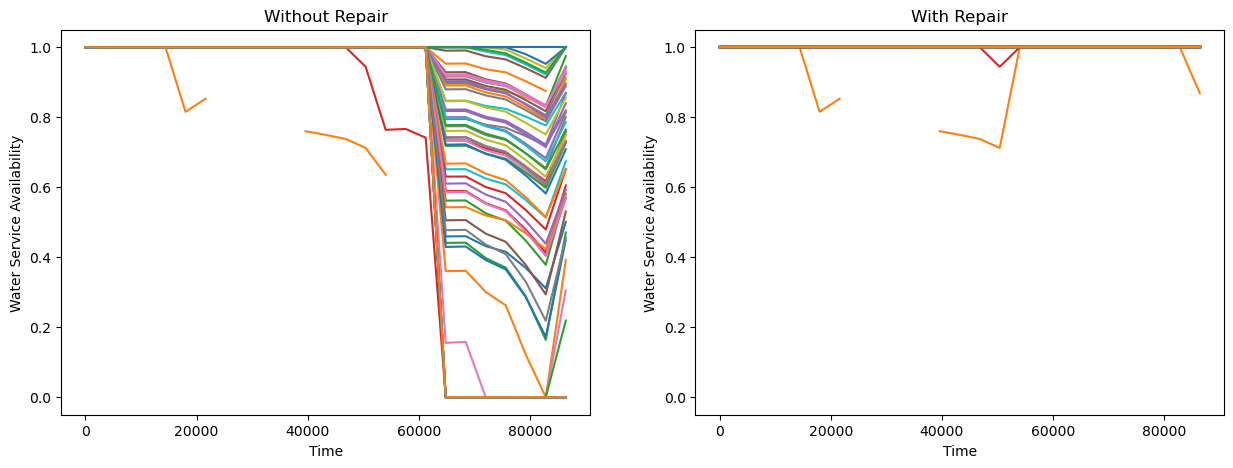

In [44]:
fig,axarr=plt.subplots(1,2,figsize=(15,5))
ax=axarr[0]
wsa.plot(ax=ax,legend=False)
ax.set_ylim(ymin=-0.05,ymax=1.05)
ax.set_xlabel('Time')
ax.set_ylabel('Water Service Availability')
ax.set_title('Without Repair')
ax=axarr[1]
wsa_wrepair.plot(ax=ax,legend=False)
ax.set_ylim(ymin=-0.05,ymax=1.05)
ax.set_xlabel('Time')
ax.set_ylabel('Water Service Availability')
ax.set_title('With Repair')

In [47]:
population=wntr.metrics.population(wn)
people_impacted=wntr.metrics.population_impacted(population,wsa.fillna(0),np.less,0.8)
people_impacted_wrepair=wntr.metrics.population_impacted(population,wsa_wrepair.fillna(0),np.less,0.8)

Text(0.5, 1.0, 'With Repair')

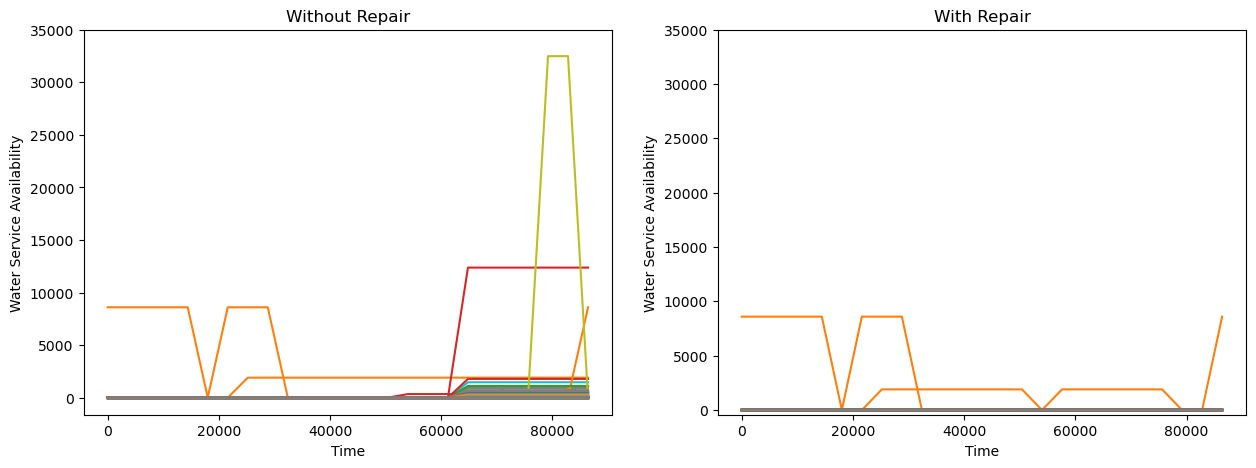

In [48]:
fig,axarr=plt.subplots(1,2,figsize=(15,5))
ax=axarr[0]
people_impacted.plot(ax=ax,legend=False)
ax.set_ylim(ymax=35000)
ax.set_xlabel('Time')
ax.set_ylabel('Water Service Availability')
ax.set_title('Without Repair')
ax=axarr[1]
people_impacted_wrepair.plot(ax=ax,legend=False)
ax.set_ylim(ymax=35000)
ax.set_xlabel('Time')
ax.set_ylabel('Water Service Availability')
ax.set_title('With Repair')

In [21]:
valve_layer=wntr.network.generate_valve_layer(wn,placement_type='strategic',n=2,seed=123)
G=wn.to_graph()
node_segments,link_segments,segment_size=wntr.metrics.valve_segments(G,valve_layer)

/home/wahab901278/anaconda3/lib/python3.11/site-packages/wntr/metrics/topographic.py:237: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  valved_link_names.append(row[0])
/home/wahab901278/anaconda3/lib/python3.11/site-packages/wntr/metrics/topographic.py:274: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  valved_node_name = link_valves.iloc[0][1]


<Axes: >

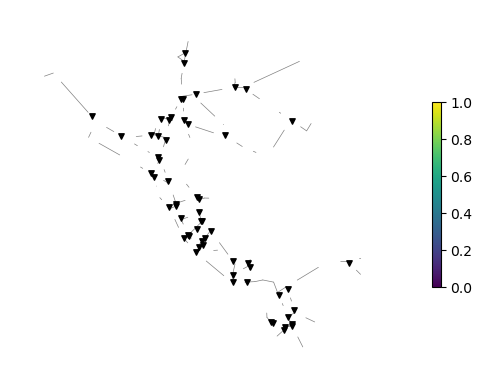

In [22]:
wntr.graphics.plot_valve_layer(wn,valve_layer,include_network=True)

In [23]:
# Seismic Retrofit

for junction_name in wn.junction_name_list:
    junction = wn.get_node(junction_name)
    junction.elevation=junction.elevation-0.5

In [24]:
sim=wntr.sim.WNTRSimulator(wn)
results=sim.run_sim()

In [25]:
leaked_demand=results.node['leak_demand']
leaked_sum=leaked_demand.sum()
leaked_sum.sort_values(ascending=False,inplace=True)

Text(0, 0.5, 'Leak Demand(m$3$/s)')

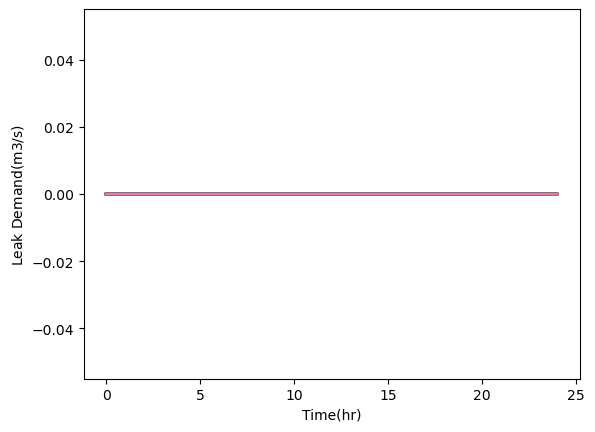

In [26]:
leaked_demand.index=leaked_demand.index/3600
ax=leaked_demand.plot(legend=False)
ax.set_xlabel('Time(hr)')
ax.set_ylabel('Leak Demand(m$3$/s)')